## Introduction to network-based analysis in biomedicine with python (Part 3)

<b> This session is based on a recent study implemented by Barabasi-LAB </b>

Network-driven Drug Repurposing for COVID-19 (from https://github.com/Barabasi-Lab/COVID-19/blob/main/01_Separation.ipynb)

Azad, A. K. M., et al. "Integrative resource for network-based investigation of COVID-19 combinatorial drug repositioning and mechanism of action." Patterns 2.9 (2021): 100325.

Morselli Gysi, Deisy, et al. "Network medicine framework for identifying drug-repurposing opportunities for COVID-19." Proceedings of the National Academy of Sciences 118.19 (2021): e2025581118.


The source code 'seperation.py' computes the network-based distance and separation for two given sets of nodes on given network as described in 

*Uncovering Disease-Disease Relationships Through The Human Interactome*

by Joerg Menche, Amitabh Sharma, Maksim Kitsak, Susan Dina, Ghiassian, Marc Vidal, Joseph Loscalzo & Albert-Laszlo Barabasi

In [1]:
# Import python modules
import networkx as nx
import numpy as np
import pandas as pd
import separation # from Barabasi-lab
import Barabasi_proximities as prox

In [2]:
# Import python modules for visualizations
import tqdm
import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

**1. We upload the PPI network, SARS-CoV2-targets and knonw disease-gene associations**

First, we upload knonw PPIs from different annotation databases and then build a network with *NetworkX*

In [3]:
ppi = pd.read_csv('./Data/Barabasi_CoV2_PPI.csv')
ppi.head()

,proteinA_entrezid,proteinB_entrezid,databases
0,9796,56992,bioplex|HIPPIE
1,7918,9240,instruct|hiunion|APID|biogrid|HINT-binary|intact
2,8233,23548,bioplex|HIPPIE
3,4899,11253,encode
4,5297,8601,bioplex


In [4]:
print(ppi.shape) # how many interactions?
print(len(set(ppi['proteinA_entrezid']).union(set(ppi['proteinB_entrezid'])))) # how many proteins?

(327924, 3)
18505


<AxesSubplot:>

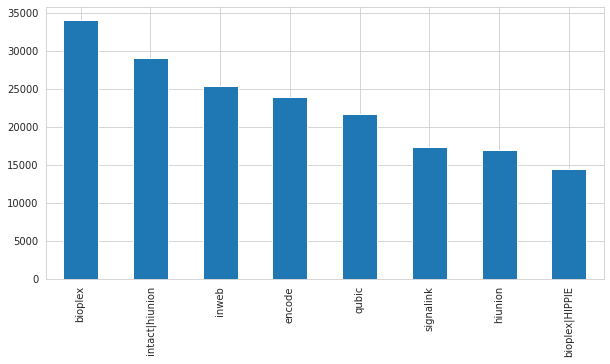

In [5]:
count_dbs = ppi['databases'].value_counts()
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
count_dbs.loc[count_dbs > 10000].plot(ax=ax, kind='bar')

In [6]:
# now we create a graph object by using the python module networkx
edges = zip(ppi.proteinA_entrezid, ppi.proteinB_entrezid)
ppi = nx.Graph()
ppi.add_edges_from(edges)

In [7]:
# extract the connected components 
graphs = (ppi.subgraph(c).copy() for c in nx.connected_components(ppi))
# let's check the number of edges and node of each connected component (THIS can be an exercise)
for g in graphs:
    if g.number_of_nodes() == 1: # skip the iteration if the connected component contains only one node
        continue
    else:
        print("--------------")
        print(g.number_of_nodes())
        print(g.number_of_edges())

--------------
18446
327868
--------------
3
2
--------------
2
1
--------------
2
1


In [8]:
# select the largest connected component
G = list(ppi.subgraph(c).copy() for c in nx.connected_components(ppi))[0]
print(len(G.nodes()), len(G.edges()))

18446 327868


In [9]:
# remove self-loops
G.remove_edges_from(nx.selfloop_edges(G))

Let's upload known associations between SARS-CoV-2 and targets/genes. 

In [10]:
dt = pd.read_csv('./Data/SARSCoV2_Targets.csv')
dt.head()

,SARS,EntrezID,Symbol
0,sars-cov2e,8546,AP3B1
1,sars-cov2e,23476,BRD4
2,sars-cov2e,6046,BRD2
3,sars-cov2e,10283,CWC27
4,sars-cov2e,124245,ZC3H18


We will now check if the PPI covers known SARS-CoV-2 targets. Moreover, we will try to extract a subgraph including only the SARS-CoV-2 targets having higher degree centrality within the PPI network. 

(332, 3)
332
382
16
[10956]
[166, 5318, 5576, 7879, 55755, 11116, 2801, 10142, 5566]
The Subgraph:


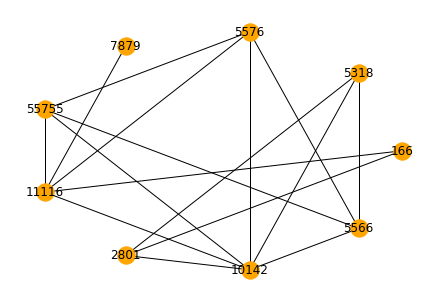

In [11]:
# check if the PPI includes all knonw SARS-CoV-2 targets
print(dt.shape)
print(len(set(G.nodes()).intersection(set(dt['EntrezID']))))

# extract a subgraph by selecting SARSCoV2 targets and all the edges between them
H = nx.Graph(G.subgraph(list(dt['EntrezID'])))
print(len(H.edges()))

# sort the nodes based (descending order) based on degree centrality 
degCent_sorted = [item[0] for item in sorted(H.degree, key=lambda x: x[1], reverse=True)]

# extract a subgraph of the top 10 central nodes
H2 = nx.Graph(H.subgraph(degCent_sorted[0:10]))
print(len(H2.edges()))

# find isolated nodes
isolated_nodes = list(nx.isolates(H2))
print(isolated_nodes)

# remove isolated nodes
H2.remove_nodes_from(isolated_nodes)

# print out remaining node names
print(H2.nodes())

#plt.subplot(111)
print("The Subgraph:")
nx.draw_circular(H2, node_color='orange', with_labels = True)

Let's show an example on how to detect communities (Girvan-Newman Algorithm)...since it is to understand

This algorithm detects communities by keeping edges that are most likely between communities and progressively removing the other edges from the original graph.

https://memgraph.com/blog/community-detection-algorithms-with-python-networkx

https://www.geeksforgeeks.org/detecting-communities-in-social-networks-using-girvan-newman-algorithm-in-python/

Let's explain quality metrics such as coverage, performance and modularity.



In [12]:
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms import community

# find and remove isolated nodes
isolated_nodes = list(nx.isolates(H))
H.remove_nodes_from(isolated_nodes)

communities = girvan_newman(H)
 
node_groups = []
for com in next(communities):
    node_groups.append(list(com))

print(community.coverage(H, node_groups))
print(community.performance(H, node_groups))
print(community.modularity(H, node_groups))

0.9921465968586387
0.3631728842164481
0.19453619692442634


14
[192, 2, 16, 5, 2, 2, 2, 2, 2, 2, 5, 2, 2, 3]
1


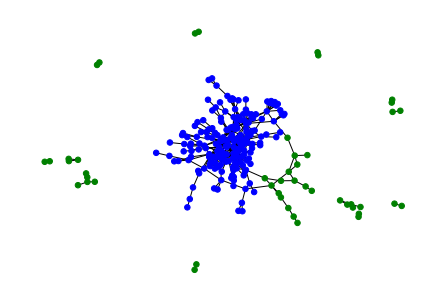

In [13]:
# check how many communities were detected and how big they are
print(len(node_groups))
print([len(com) for com in node_groups])

# select the communities with at least twenty five nodes
node_groups = [com for com in node_groups if len(com) > 25]
print(len(node_groups))

# define the color map
color_map = []
for node in H:
    if node in node_groups[0]:
        color_map.append('blue')
    else:
        color_map.append('green')
        
nx.draw(H, node_color=color_map, with_labels=False,  node_size = 30)
plt.show()

**The first objective of this NDM application is to study the association between COVID-19 and other diseases.**

To this end we need to upload knonw disease-gene associations 

In [14]:
# Disease-gene associations were retrieved from OMIM and GWAS catalog using UniProtKB and PheGenI 
disease2genes = {}
for i in open('./Data/Guney2016_GenesDisease.tsv').readlines():
    v = i.rstrip().split('\t')
    disease = v[1]
    genes = v[2:]
    if len(genes) > 19:
        disease2genes[disease] = [int(i) for i in genes]

In [15]:
diseasegenes = list(disease2genes.values())
diseasegenes = sum(diseasegenes, [])
diseasegenes = list(set(diseasegenes))
len(diseasegenes)

3173

<b> Network separation between the SARSCov2 targets and known targets of other diseases </b>

**Network-based localization measures**

Network-based proximity is based on network-based localization measures. The figure below (Supplementary Figure S4-a from www.sciencemag.org/content/347/6224/1257601/suppl/DC1) an example of disease genes (red) that form one connected cluster of six genes, one cluster of two genes and one gene without connection to other disease genes. The size of the observable module is therefore given by S = 6. For three genes, A,B and C, the respective shortest distance to the next closest other disease gene is shown. 

<img src="./Figures/FigureS1.png" alt="drawing" width="500"/>

**Network separation**

We quantify the network-based separation $S_{AB}$ between their proteins: of two diseases A and B by comparing the mean shortest distances $\langle d_{AA} \rangle$ and $\langle d_{BB} \rangle$ within the respective diseases, to the mean shortest distance $\langle d_{AB} \rangle$ between their proteins:

<img src="./Figures/SeparationMeasure.png" alt="drawing" width="300"/>

The figure below shows the network-based separation measure for two diseases A (blue) and B (red) with one shared protein (“c”). The tables on the right give the values of the mean shortest distances within the diseases, $\langle d_{AA} \rangle$ and $\langle d_{BB} \rangle$, as well as the distances for all protein pairs between them, $\langle d_{AB} \rangle$.

<img src="./Figures/FigureS5.png" alt="drawing" width="700"/>

Supplementary Figure S5 www.sciencemag.org/content/347/6224/1257601/suppl/DC1

In [ ]:
sab = {}
for disease in tqdm.tqdm(disease2genes.keys()):

    genes_A = set(dt.EntrezID) & set(G.nodes())
    genes_B = set(disease2genes[disease]) & set(G.nodes())
    d_A = separation.calc_single_set_distance(G,genes_A)
    d_B = separation.calc_single_set_distance(G,genes_B)

    # distances BETWEEN the two gene sets:
    d_AB = separation.calc_set_pair_distances(G,genes_A,genes_B)

    # calculate separation
    s_AB = d_AB - (d_A + d_B)/2.
    sab[disease] = s_AB

  0%|          | 0/299 [00:00<?, ?it/s]

In [ ]:
dx = pd.DataFrame.from_dict(sab, orient='index')
dx = dx.reset_index()
dx.columns = ['disease', 'sab']
dx.head()

,disease,sab
0,kidney diseases,0.150809
1,chromosome disorders,0.340531
2,"diabetes mellitus, type 1",0.219150
3,cardiomegaly,0.377554
4,anemia,0.470873


In [ ]:
dx.to_csv('.//sab_virustargets.csv')

/shared-libs/python3.9/py/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


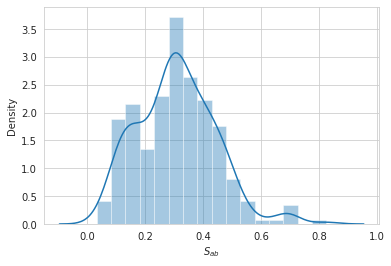

In [ ]:
fig, ax = plt.subplots(1,1)
sns.distplot(dx['sab'],ax=ax)
ax.set_xlabel('$S_{ab}$')
ax.set_ylabel('Density')
fig.savefig('./Outputs/sab_virus_dist.png', dpi = 300)

**Drug repurposing opportunities by crossing known SARS-CoV2 target (genes) with knonw drug-target associations**

We measure the network proximity between drug–targets (A) and  SARS-CoV2-targets (B), using the recently introduced separation measure. 

<img src="./Figures/SeparationMeasure.png" alt="drawing" width="300"/>

For $S_{AB}$ < 0, the targets of the two drugs are located in the same network neighborhood, while for $S_{AB}$ ≥ 0, the two target sets are topologically separated. 

In [ ]:
d2g = pd.read_csv('./Data/drug2targets.csv')
d2g.head()

,Unnamed: 0,type,ID,Name,State,Approved,Indication,Gene_Target,DB_id,name,organism,Type,entrez_id,ATC_code
0,0,biotech,DB00001,Lepirudin,liquid,approved,For the treatment of heparin-induced thrombocy...,F2,BE0000048,Prothrombin,Humans,Polypeptide,2147.0,B01AE02
1,1,biotech,DB00002,Cetuximab,liquid,approved,"Cetuximab, used in combination with irinotecan...",EGFR,BE0002100,Low affinity immunoglobulin gamma Fc region re...,Humans,Polypeptide,1956.0,L01XC06
2,2,biotech,DB00002,Cetuximab,liquid,approved,"Cetuximab, used in combination with irinotecan...",FCGR3B,BE0002100,Low affinity immunoglobulin gamma Fc region re...,Humans,Polypeptide,2215.0,L01XC06
3,3,biotech,DB00002,Cetuximab,liquid,approved,"Cetuximab, used in combination with irinotecan...",C1R,BE0002100,Low affinity immunoglobulin gamma Fc region re...,Humans,Polypeptide,715.0,L01XC06
4,4,biotech,DB00002,Cetuximab,liquid,approved,"Cetuximab, used in combination with irinotecan...",C1QA,BE0002100,Low affinity immunoglobulin gamma Fc region re...,Humans,Polypeptide,712.0,L01XC06


In [ ]:
print(d2g.shape)
print(len(d2g['Name'].unique())) # how many different drugs we have?
print(d2g['State'].unique())     # drug state
print(d2g['Approved'].unique())  # what is the current status of these drugs

(24648, 14)
6137
['liquid' 'solid' nan 'gas']
['approved' 'experimental' 'investigational' 'nutraceutical' 'withdrawn'
 'illicit' 'vet_approved' nan]


In [ ]:
d2g = d2g.loc[d2g['Approved'].isin(['approved', 'experimental', 'investigational', 'vet_approved'])]
print(len(d2g['Name'].unique()))

6089


<img src="./Figures/Table1.png" alt="drawing" width="600"/>

In [ ]:
print('Sofosbuvir' in set(d2g['Name']))
print('Ivermectin' in set(d2g['Name']))

True
True


In [ ]:
# prepare known drug-target associations 
drug2targets = {}
list_drugs_to_inv = ['Vincristine','Doxazosin', 'Promazine', 'Ivermectin','Ulipristal']
for d in list_drugs_to_inv: 
    drug2targets[d] = [int(e) for e in d2g.loc[d2g['Name'] == d, 'entrez_id']]

In [ ]:
for drug in list_drugs_to_inv:
    print(drug)
    genes_A = set(dt.EntrezID) & set(G.nodes())
    genes_B = set(drug2targets[drug]) & set(G.nodes())
    print(len(genes_B))

    d_A = separation.calc_single_set_distance(G,genes_A)
    d_B = separation.calc_single_set_distance(G,genes_B)

    # distances BETWEEN the two gene sets:
    d_AB = separation.calc_set_pair_distances(G,genes_A,genes_B)

    # calculate separation
    s_AB = d_AB - (d_A + d_B)/2

    print(s_AB)

Vincristine
15
0.4383878453294445
Doxazosin
12
0.6001447651069394
Promazine
19
0.6841131959235951
Ivermectin
8
0.4208982990786676
Ulipristal
7
0.39948986844977896


**The same network can be used to test other network data mining algorithms**

For instance compute centrality scores for SARSCOV2 targets (which can be also an exercise)

Use community detection to identify SARSCOV2-related modules withih the assigned PPI

Use RWR to study the overlap between SARSCOV2 targets and known drug-target associations

**Network-based proximity between drugs and diseases**

The proximity between a disease and a drug was evaluated using various distance measures that take into account the path lengths between drug targets and disease proteins. Given S, the set of disease proteins, T, the set of drug targets and d(s,t), the shortest path length between nodes s and t in the network, we define:

Closest
Shortest
Kernel

(https://www.nature.com/articles/ncomms10331#Sec12)

ThETA-based approach

* weighted average of shortest paths between SARS-CoV-targets and drug targets
* the weight indicate how central is a node (discretize node centrality scores with the bin technique and associate) 

http://vafaeelab.com/COVID19_repositioning.html

In [ ]:
# prepare known drug-target associations 
drug2targets = {}
list_drugs_to_inv = ['Vincristine','Doxazosin', ]
for d in list_drugs_to_inv: 
    drug2targets[d] = [int(e) for e in d2g.loc[d2g['Name'] == d, 'entrez_id']]

In [ ]:
Drug_proximities = pd.DataFrame()

for drug in list_drugs_to_inv:
    print(drug)
    genes_A = set(dt.EntrezID) & set(G.nodes())

    genes_B = set(drug2targets[drug]) & set(G.nodes())
    print(len(genes_B))

    proximity_closest = prox.proximity_closest(G, genes_A, genes_B)
    proximity_shortest = prox.proximity_shortest(G, genes_A, genes_B)
    proximity_kernel = prox.proximity_kernel(STRING_PPI, geneSet1, geneSet2)
    
    topological_centre = prox.get_topological_centre(G, genes_A)
    proximity_centre = prox.proximity_centre(G, topological_centre, genes_B)

    tmp = pd.DataFrame({"Drug" : drug, 
                            "proximity_closest" : proximity_closest,
                            "proximity_shortest" : proximity_shortest,
                            "proximity_kernel" : proximity_kernel,
                            "proximity_centre" : proximity_centre}, index = [0])
    Drug_proximities = pd.concat([Drug_proximities, tmp]).reset_index(drop = True)


Vincristine
15
Doxazosin
12


In [ ]:
Drug_proximities

,Drug,proximity_closest,proximity_shortest,proximity_centre
0,Vincristine,1.978916,2.590046,2.000000
1,Doxazosin,2.183735,2.871486,2.333333


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d6f9e27d-71eb-4664-8c0d-e7e02cc44214' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>